# xậy dựng mô hình huần huef gì đó

In [1]:
# tải thư viện lightgbm phiên bản 4.5.0
#!pip install lightgbm==4.5.0
#!pip install optuna==4.4.0

- import thư viện cần thiết

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline

import lightgbm as lgb
import optuna

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/home/uyennguyen/miniconda3/envs/min_ds-env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## TIỀN XỬ LÝ DỮ LIỆU

In [3]:
df = pd.read_csv("../Data/Dataset_clean.csv")
df.head(5)

,sale_date,sale_price,join_status,latitude,longitude,area,city,zoning,subdivision,present_use,...,view_lakesamm,view_otherwater,view_other,submarket,sale_nbr_missing,garb_sqft_clipped,sqft_lot_log,sale_nbr_log,imp_val_log,is_2025
0,2014-11-15,236000,nochg,47.2917,-122.3658,53,FEDERAL WAY,RS7.2,ALDERWOOD SOUTH DIV NO. 02,2,...,0,0,0,I,0,0,9.298351,1.098612,12.826652,1
1,1999-01-15,313300,nochg,47.6531,-122.1996,74,KIRKLAND,RS 8.5,WILDWOOD LANE NO. 03,2,...,0,0,0,Q,1,0,9.093919,0.000000,13.301348,1
2,2006-08-15,341000,nochg,47.4733,-122.1901,30,RENTON,R-8,FALCON RIDGE (CEDAR RIDGE),2,...,0,0,0,K,0,0,8.507951,0.693147,12.782689,1
3,1999-12-15,267000,nochg,47.4739,-122.3295,96,BURIEN,RS-7200,OLYMPIC VUE ESTATES,2,...,0,0,0,G,0,0,8.824678,0.693147,13.157732,1
4,2018-07-15,1650000,miss99,47.7516,-122.1222,36,KING COUNTY,RA2.5,HOLLYWOOD HILL HIGHLANDS,2,...,0,0,0,P,0,0,10.363693,1.098612,14.466273,1


In [4]:
test_df = pd.read_csv("../Data/test_clean.csv")
test_df.head()

,sale_date,join_status,latitude,longitude,area,city,zoning,subdivision,present_use,land_val,...,view_lakesamm,view_otherwater,view_other,submarket,sale_nbr_missing,garb_sqft_clipped,sqft_lot_log,sale_nbr_log,imp_val_log,is_2025
0,2022-12-15,new,47.4794,-122.2212,25,RENTON,R-8,TOWN-COUNTRY CLUB BUNGALOW SITES,2,320000,...,0,0,0,J,0,0,8.325548,1.609438,13.284484,1
1,2000-10-15,new,47.5778,-122.0270,69,SAMMAMISH,R1,unknown,2,491000,...,0,0,0,O,0,0,10.276085,1.098612,14.079413,1
2,2004-06-15,nochg,47.5632,-122.1623,31,BELLEVUE,R-3.5,SOMERSET NO. 08,2,1292000,...,0,0,0,R,0,0,9.071193,0.693147,12.906694,1
3,2009-11-15,nochg,47.6911,-122.3469,6,SEATTLE,LR1 (M1),NEVINS DIV OF GREEN LAKE ADD,2,500000,...,0,0,0,B,0,0,8.537192,0.693147,12.581082,1
4,1999-06-15,reno - before,47.4001,-122.4146,100,KING COUNTY,RA2.5P,unknown,2,124000,...,0,0,0,H,0,0,10.768085,0.693147,12.531776,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sale_date          199999 non-null  object 
 1   sale_price         199999 non-null  int64  
 2   join_status        199999 non-null  object 
 3   latitude           199999 non-null  float64
 4   longitude          199999 non-null  float64
 5   area               199999 non-null  int64  
 6   city               199999 non-null  object 
 7   zoning             199999 non-null  object 
 8   subdivision        199999 non-null  object 
 9   present_use        199999 non-null  int64  
 10  land_val           199999 non-null  int64  
 11  year_built         199999 non-null  int64  
 12  year_reno          199999 non-null  int64  
 13  sqft               199999 non-null  int64  
 14  sqft_1             199999 non-null  int64  
 15  sqft_fbsmt         199999 non-null  int64  
 16  gr

### xử lý sale-date

In [6]:
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['year'] = df['sale_date'].dt.year
df['month'] = df['sale_date'].dt.month
df['day'] = df['sale_date'].dt.day
df = df.drop(columns=['sale_date'])

In [7]:
test_df['sale_date'] = pd.to_datetime(test_df['sale_date'])
test_df['year'] = test_df['sale_date'].dt.year
test_df['month'] = test_df['sale_date'].dt.month
test_df['day'] = test_df['sale_date'].dt.day
test_df = test_df.drop(columns=['sale_date'])

### chia feature/label

In [8]:
y = df['sale_price']
X = df.drop(columns=['sale_price'])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (199999, 47)
y shape: (199999,)


### Chia train/valid/test

In [9]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42)
X_test = test_df.copy()

- check phân phối giá trị của train và valid

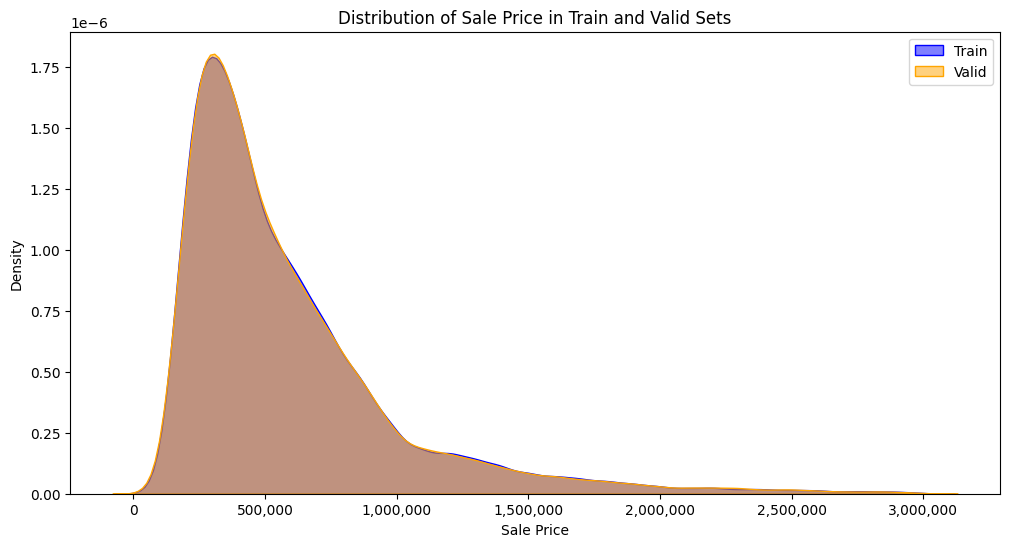

In [10]:
# biểu đồ phân phối kde-plot của sale_price trong tập train và valid
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Train', color='blue', fill=True, alpha=0.5)
sns.kdeplot(y_valid, label='Valid', color='orange', fill=True, alpha=0.5)
# định dạng giá trị là giá trị đầy đủ
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
#plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.title('Distribution of Sale Price in Train and Valid Sets')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.legend()
plt.show()

In [11]:
columns = X_train.columns.tolist()

### Xử lý cột numerical

In [12]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols

['latitude',
 'longitude',
 'area',
 'present_use',
 'land_val',
 'year_built',
 'year_reno',
 'sqft',
 'sqft_1',
 'sqft_fbsmt',
 'grade',
 'fbsmt_grade',
 'condition',
 'stories',
 'beds',
 'bath_full',
 'bath_3qtr',
 'bath_half',
 'gara_sqft',
 'wfnt',
 'golf',
 'greenbelt',
 'noise_traffic',
 'view_rainier',
 'view_olympics',
 'view_cascades',
 'view_territorial',
 'view_skyline',
 'view_sound',
 'view_lakewash',
 'view_lakesamm',
 'view_otherwater',
 'view_other',
 'sale_nbr_missing',
 'garb_sqft_clipped',
 'sqft_lot_log',
 'sale_nbr_log',
 'imp_val_log',
 'is_2025']

In [13]:
# standard_scaler = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

In [14]:
# standard_cols = []


# normalize_pipeline = Pipeline(steps=[
#     ('scaler', StandardScaler(), standard_cols)
# ])

### Encode cột phân loại

In [15]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['join_status', 'city', 'zoning', 'subdivision', 'submarket']

In [16]:
# model = LGBMRegressor()
# model.fit(X_train, y_train)

# selector = SelectFromModel(model, threshold='mean', prefit=True)
# X_train_selected = selector.transform(X_train)
# X_valid_selected = selector.transform(X_valid)

In [17]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.frequency_maps = {}

    def fit(self, X, y=None):
        # Học tần suất từ X_train
        for col in X.columns:
            self.frequency_maps[col] = X[col].value_counts(normalize=True).to_dict()
            # Normalize=True để lấy tần suất tương đối (tỷ lệ), thường tốt hơn số đếm tuyệt đối.
            # Nếu bạn muốn số đếm tuyệt đối, bỏ normalize=True.
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in X.columns:
            # Áp dụng tần suất đã học. Xử lý giá trị mới (unseen) bằng 0 hoặc tần suất trung bình.
            # Ở đây ta dùng get(key, default_value) để trả về 0 nếu không tìm thấy key.
            # Tùy thuộc vào domain, bạn có thể thay default_value bằng một giá trị khác như X[col].mean()
            X_encoded[col] = X_encoded[col].map(self.frequency_maps[col])
        return X_encoded

In [18]:
# One-Hot Encoder: handle_unknown='ignore' để xử lý các giá trị mới trong tập kiểm tra
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Ordinal Encoder (Label Encoder):
label_transformer = Pipeline(steps=[
    ('label', OrdinalEncoder())
])

# Frequency Encoder
frequency_transformer = Pipeline(steps=[
    ('freq_enc', FrequencyEncoder())
])

In [19]:
onehot_cols = ['join_status']
ordinal_cols = ['submarket'] # Tên cột để dùng cho OrdinalEncoder
frequent_cols = ['city', 'zoning', 'subdivision']

encode_pipeline = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_cols),
        ('label', label_transformer, ordinal_cols),
        ('freq', frequency_transformer, frequent_cols)
    ],
    remainder='passthrough')

In [20]:
X_train_processed = encode_pipeline.fit_transform(X_train)
X_valid_processed = encode_pipeline.transform(X_valid)
X_test_processed = encode_pipeline.transform(X_test)

In [21]:
# Tìm các cột được giữ lại (passthrough)
used_cols = set(onehot_cols + ordinal_cols + frequent_cols)
passthrough_cols = [col for col in X_train.columns if col not in used_cols]

# OneHot: tên có thêm prefix
onehot_names = encode_pipeline.named_transformers_['onehot'].get_feature_names_out(onehot_cols)

# Các cột ordinal và freq giữ nguyên tên
label_names = ordinal_cols
freq_names = frequent_cols

# Gộp lại đúng thứ tự
all_feature_names = list(onehot_names) + label_names + freq_names + passthrough_cols

In [22]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_valid_processed_df = pd.DataFrame(X_valid_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

In [23]:
X_train_processed_df.columns

Index(['join_status_demo', 'join_status_miss99', 'join_status_new',
       'join_status_nochg', 'join_status_rebuilt - after',
       'join_status_rebuilt - before', 'join_status_reno - after',
       'join_status_reno - before', 'submarket', 'city', 'zoning',
       'subdivision', 'latitude', 'longitude', 'area', 'present_use',
       'land_val', 'year_built', 'year_reno', 'sqft', 'sqft_1', 'sqft_fbsmt',
       'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full',
       'bath_3qtr', 'bath_half', 'gara_sqft', 'wfnt', 'golf', 'greenbelt',
       'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades',
       'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash',
       'view_lakesamm', 'view_otherwater', 'view_other', 'sale_nbr_missing',
       'garb_sqft_clipped', 'sqft_lot_log', 'sale_nbr_log', 'imp_val_log',
       'is_2025', 'year', 'month', 'day'],
      dtype='object')

In [24]:
# rename columns join_status_reno - after, join_status_reno - before, join_status_rebuilt - before, join_status_rebuilt - after
def clean_text(s):
    return s.strip().lower().replace(' ', '') .replace('-', '_') 

X_train_processed_df.columns = [clean_text(col) for col in X_train_processed_df.columns]
X_valid_processed_df.columns = [clean_text(col) for col in X_valid_processed_df.columns]
X_test_processed_df.columns = [clean_text(col) for col in X_test_processed_df.columns]

### làm gì gì đó nữa

## CHỌN ĐẶC TRƯNG QUAN TRỌNG VÀO MÔ HÌNH

In [25]:
model = lgb.LGBMRegressor(verbose=-1, random_state=42)
model.fit(X_train_processed_df, y_train)

LGBMRegressor(random_state=42, verbose=-1)

In [26]:
importances_split = model.booster_.feature_importance(importance_type='split')
importances_gain = model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

importances_df = pd.DataFrame({
    'feature': feature_names,
    'split_importance': importances_split,
    'gain_importance': importances_gain
}).sort_values(by='gain_importance', ascending=False)
importances_df

,feature,split_importance,gain_importance
51,year,502,3.689259e+16
49,imp_val_log,291,1.907540e+16
16,land_val,422,1.337688e+16
22,grade,97,8.884916e+15
12,latitude,169,6.706274e+15
19,sqft,159,5.109683e+15
5,join_status_rebuilt_before,88,3.169091e+15
50,is_2025,69,2.161088e+15
8,submarket,128,1.897262e+15
4,join_status_rebuilt_after,73,1.183202e+15


In [27]:
# # chọn những feature có gain để train mô hình thực sự 
# fill_df = importances_df[importances_df['gain_importance'] >= 1e14]
# features_apply_model = importances_df['feature']

In [28]:
# chọn những feature có split_important > 3 để train mô hình thực sự 
fill_df = importances_df[(importances_df["split_importance"] > 3)]
features_apply_model = importances_df['feature']

## MODELING

### Hàm loss được sử dụng

In [29]:
def winkler_score(y_true, lower, upper, alpha=0.1):
    """Compute the Winkler Interval Score for prediction intervals.

    Args:
        y_true (array-like): True observed values.
        lower (array-like): Lower bounds of prediction intervals.
        upper (array-like): Upper bounds of prediction intervals.
        alpha (float): Significance level (e.g., 0.1 for 90% intervals).

    Returns:
        score (float): Mean Winkler Score.
        coverage (float, optional): Proportion of true values within intervals.
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    return np.mean(score)

### Hàm tính coverage & width

In [30]:
def evaluate_quantile(y_true, y_lower, y_upper):
    coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))
    width = np.mean(y_upper - y_lower)
    return coverage, width

- dữ liệu sẽ được áp dụng vào model

In [31]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
mask = iso.fit_predict(X_train_processed_df) == 1

X_train_clean = X_train_processed_df[mask]
y_train_clean = y_train[mask]

In [32]:
# mask_valid = iso.predict(X_valid_processed_df) == 1

# X_valid_clean = X_valid_processed_df[mask_valid]
# y_valid_clean = y_valid[mask_valid]

- Một với X_valid gốc để đánh giá mô hình trong thực tế

In [33]:
X_train_model = X_train_clean[features_apply_model]
X_valid_model = X_valid_processed_df[features_apply_model]
X_test_model = X_test_processed_df[features_apply_model]

In [34]:
y_train_model = np.log1p(y_train_clean)  # log transform to stabilize variance
y_valid_model = np.log1p(y_valid)  # log transform to stabilize variance

In [35]:
# X_train_model = X_train_processed_df[features_apply_model]
# X_valid_model = X_valid_processed_df[features_apply_model]
# X_test_model = X_test_processed_df[features_apply_model]

In [36]:
# y_train_model = np.log1p(y_train)  # log transform to stabilize variance
# y_valid_model = np.log1p(y_valid)  # log transform to stabilize variance

In [37]:
def objective(trial):
    params = {
        "objective": "quantile",
        "alpha": 0.01,  # hoặc 0.95 cho upper
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": 300,
        "verbosity": -1,
        "random_state": 42
    }

    model_lower = lgb.LGBMRegressor(**{**params, "alpha": 0.05})
    model_upper = lgb.LGBMRegressor(**{**params, "alpha": 0.95})

    model_lower.fit(X_train_model, y_train_model)
    model_upper.fit(X_train_model, y_train_model)

    lower_log = model_lower.predict(X_valid_model)
    upper_log = model_upper.predict(X_valid_model)

    lower = np.expm1(lower_log)  # chuyển đổi ngược lại từ log
    upper = np.expm1(upper_log)  # chuyển đổi ngược lại từ log

    loss = winkler_score(y_valid, lower, upper, alpha=0.1)
    return loss  # càng thấp càng tốt

In [38]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best trial:", study.best_trial.number)
print("Best Winkler Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)

[I 2025-07-11 13:45:20,902] A new study created in memory with name: no-name-f97465d6-925a-47f8-8811-822492a99b7e
[I 2025-07-11 13:45:24,469] Trial 0 finished with value: 428817.0888314757 and parameters: {'learning_rate': 0.030258734978314654, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.7975591294038267, 'colsample_bytree': 0.6128510177651085}. Best is trial 0 with value: 428817.0888314757.
[I 2025-07-11 13:45:27,853] Trial 1 finished with value: 367901.5416442387 and parameters: {'learning_rate': 0.07611796346393056, 'num_leaves': 22, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.639604966291191, 'colsample_bytree': 0.6486975284564128}. Best is trial 1 with value: 367901.5416442387.
[I 2025-07-11 13:45:31,377] Trial 2 finished with value: 379721.93473254354 and parameters: {'learning_rate': 0.06184717433505736, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.714528931599062, 'colsample_bytree': 0.8918086914012016}. Best

Best trial: 11
Best Winkler Score: 356517.9070475535
Best hyperparameters: {'learning_rate': 0.1253617725133603, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.9178145175380494, 'colsample_bytree': 0.8409604618300128}


In [39]:
best_params = study.best_trial.params
best_lower = lgb.LGBMRegressor(**{**best_params, "objective": "quantile", "alpha": 0.05, "random_state": 42})
best_upper = lgb.LGBMRegressor(**{**best_params, "objective": "quantile", "alpha": 0.95, "random_state": 42})

In [40]:
best_lower.fit(X_train_model, y_train_model)
best_upper.fit(X_train_model, y_train_model)

train_pred_lower_log = best_lower.predict(X_train_model)
train_pred_upper_log = best_upper.predict(X_train_model)

train_pred_lower = np.expm1(train_pred_lower_log)  # chuyển đổi ngược lại từ log
train_pred_upper = np.expm1(train_pred_upper_log)  # chuyển đổi ngược

score = winkler_score(y_train_clean, train_pred_lower, train_pred_upper, alpha=0.1)
coverage, width = evaluate_quantile(y_train_clean, train_pred_lower, train_pred_upper)
# score = winkler_score(y_train, train_pred_lower, train_pred_upper, alpha=0.1)
# coverage, width = evaluate_quantile(y_train, train_pred_lower, train_pred_upper)
print(f"Train Coverage: {coverage:.4f}, Train Width: {width:.4f}")
print(f"Train Winkler Score: {score:.4f}")

Train Coverage: 0.9039, Train Width: 271072.9867
Train Winkler Score: 345756.9025


In [41]:
valid_pred_lower_log = best_lower.predict(X_valid_model)
valid_pred_upper_log = best_upper.predict(X_valid_model)

valid_pred_lower = np.expm1(valid_pred_lower_log)  # chuyển đổi ngược lại từ log
valid_pred_upper = np.expm1(valid_pred_upper_log)  # chuyển đổi ngược lại từ log

coverage, width = evaluate_quantile(y_valid, valid_pred_lower, valid_pred_upper)
score = winkler_score(y_valid, valid_pred_lower, valid_pred_upper, alpha=0.1)
print(f"Validation Coverage: {coverage:.4f}, Validation Width: {width:.4f}")
print(f"Validation Winkler Score: {score:.4f}")

Validation Coverage: 0.8901, Validation Width: 276992.4895
Validation Winkler Score: 384707.6375


In [42]:
test_pred_lower_log = best_lower.predict(X_test_model)
test_pred_upper_log = best_upper.predict(X_test_model)

test_pred_lower = np.expm1(test_pred_lower_log)  # chuyển đổi ngược lại từ log
test_pred_upper = np.expm1(test_pred_upper_log)  # chuyển đổi ngược

submission_df = pd.DataFrame()
submission_df['id'] = range(200000, 400000)
submission_df['pi_lower'] = test_pred_lower
submission_df['pi_upper'] = test_pred_upper

submission_df.to_csv("../Data/submission.csv", index=False)

In [43]:
# from optuna.integration import LightGBMTunerCV

# params = {
#     "objective": "regression",
#     "metric": "rmse",
#     "verbosity": -1,
#     "boosting_type": "gbdt",
#     "random_state": 42,
# }

# dtrain = lgb.Dataset(X_train, label=y_train)

# best_params = lgb_optuna.LightGBMTunerCV(
#     params,
#     dtrain,
#     early_stopping_rounds=50,
#     verbose_eval=100,
#     nfold=5,
# )

# best_params.run()
# print("Best params:", best_params.best_params)

In [44]:
# def get_feature_names(column_transformer):
#     output_features = []

#     for name, transformer, columns in column_transformer.transformers_:
#         if name == 'remainder' and transformer == 'passthrough':
#             output_features += list(columns)
#         elif hasattr(transformer, 'named_steps'):
#             encoder = transformer.named_steps.get('encoder')
#             if hasattr(encoder, 'get_feature_names_out'):
#                 new_names = encoder.get_feature_names_out(columns)
#                 output_features += list(new_names)
#             else:
#                 output_features += list(columns)
#         else:
#             output_features += list(columns)
#     return output_features

In [45]:
# # Gọi sau khi đã fit encode_pipeline và model
# feature_names = get_feature_names(encode_pipeline)

# importances = model.feature_importances_

# feature_importance_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': importances
# }).sort_values(by='importance', ascending=False)

# print(feature_importance_df)